# Dominant Wavelength

In [1]:
%matplotlib inline

In [2]:
import numpy as np

from colour import (
    XYZ_to_xy,
    CMFS,
    ILLUMINANTS,
    tsplit,
    tstack,
    warning)

def euclidean_distance(a, b):
    return np.linalg.norm(np.asarray(a) - np.asarray(b), axis=-1)
    
def counterclockwise(a, b, c):
    ax, ay = tsplit(a)
    bx, by = tsplit(b)
    cx, cy = tsplit(c)

    return np.greater((cy - ay) * (bx - ax), (by - ay) * (cx - ax))


def segments_intersect(a, b, c, d):
    return np.logical_and(
        np.not_equal(counterclockwise(a, c, d), counterclockwise(b, c, d)),
        np.not_equal(counterclockwise(a, b, c), counterclockwise(a, b, d)))


def extend_segment(a, b, length=1):
    # http://stackoverflow.com/questions/7740507/extend-a-line-segment-a-specific-distance
    ax, ay = tsplit(a)
    bx, by = tsplit(b)

    d = euclidean_distance(a, b)

    cx = bx + (bx - ax) / d * length
    cy = by + (by - ay) / d * length

    c = tstack((cx, cy))

    return c


def point_to_segment_distance(a, b, c):
    # http://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    ax, ay = tsplit(a)
    bx, by = tsplit(b)
    cx, cy = tsplit(c)

    px = bx - ax
    py = by - ay

    u = ((cx - ax) * px + (cy - ay) * py) / (px * px + py * py)

    u[u > 1] = 1
    u[u < 0] = 0

    dx = ax + u * px - cx
    dy = ay + u * py - cy

    d = np.sqrt(dx ** 2 + dy ** 2)

    return d


def closest_spectral_locus_wavelength_index(xy1, xy2, xy_c, reverse=False):

    xy3 = (extend_segment(xy1, xy2)
           if reverse else
           extend_segment(xy2, xy1))
    d = point_to_segment_distance(xy2, xy3, xy_c)
    i = np.argmin(d)

    return i


def dominant_wavelength(xy,
                        xy_n,
                        cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):
    xy_c = XYZ_to_xy(cmfs.values)

    xy3 = extend_segment(xy_n, xy)
    if segments_intersect(xy_n, xy3, xy_c[0], xy_c[-1]):
        warning('"{0}" chromaticity coordinates have no "dominant wavelength", '
                'computing "complementary dominant wavelength" in lieu!'.format(xy))
        i_w = closest_spectral_locus_wavelength_index(xy, xy_n, xy_c, True)
        w, xy_w = -cmfs.wavelengths[i_w], xy_c[i_w]
    else:
        i_w = closest_spectral_locus_wavelength_index(xy, xy_n, xy_c)
        w, xy_w = cmfs.wavelengths[i_w], xy_c[i_w]
        
    return w, xy_w


def complementary_wavelength(xy,
                             xy_n,
                             cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):
    xy_c = XYZ_to_xy(cmfs.values)
    
    xy3 = extend_segment(xy, xy_n)
    if segments_intersect(xy_n, xy3, xy_c[0], xy_c[-1]):
        raise RuntimeError('"{0}" chromaticity coordinates have no "complementary wavelength"!'.format(xy))
    
    i_w = closest_spectral_locus_wavelength_index(xy, xy_n, xy_c, True)
    
    return cmfs.wavelengths[i_w], xy_c[i_w]


def excitation_purity(xy,
                      xy_n,
                      cmfs=CMFS['CIE 1931 2 Degree Standard Observer']):

    w, xy_w = dominant_wavelength(xy, xy_n, cmfs)
    
    e_p = euclidean_distance(xy_n, xy) / euclidean_distance(xy_n, xy_w)
    
    return e_p
    

In [3]:
xy = (0.2835, 0.6870)
E = ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['E']
print('Dominant Wavelength: {0}'.format(dominant_wavelength(xy, E)))
print('Excitation Purity: {0}'.format(excitation_purity(xy, E)))


Dominant Wavelength: (547.0, array([ 0.28012894,  0.71172473]))
Excitation Purity: 0.934696756529


//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


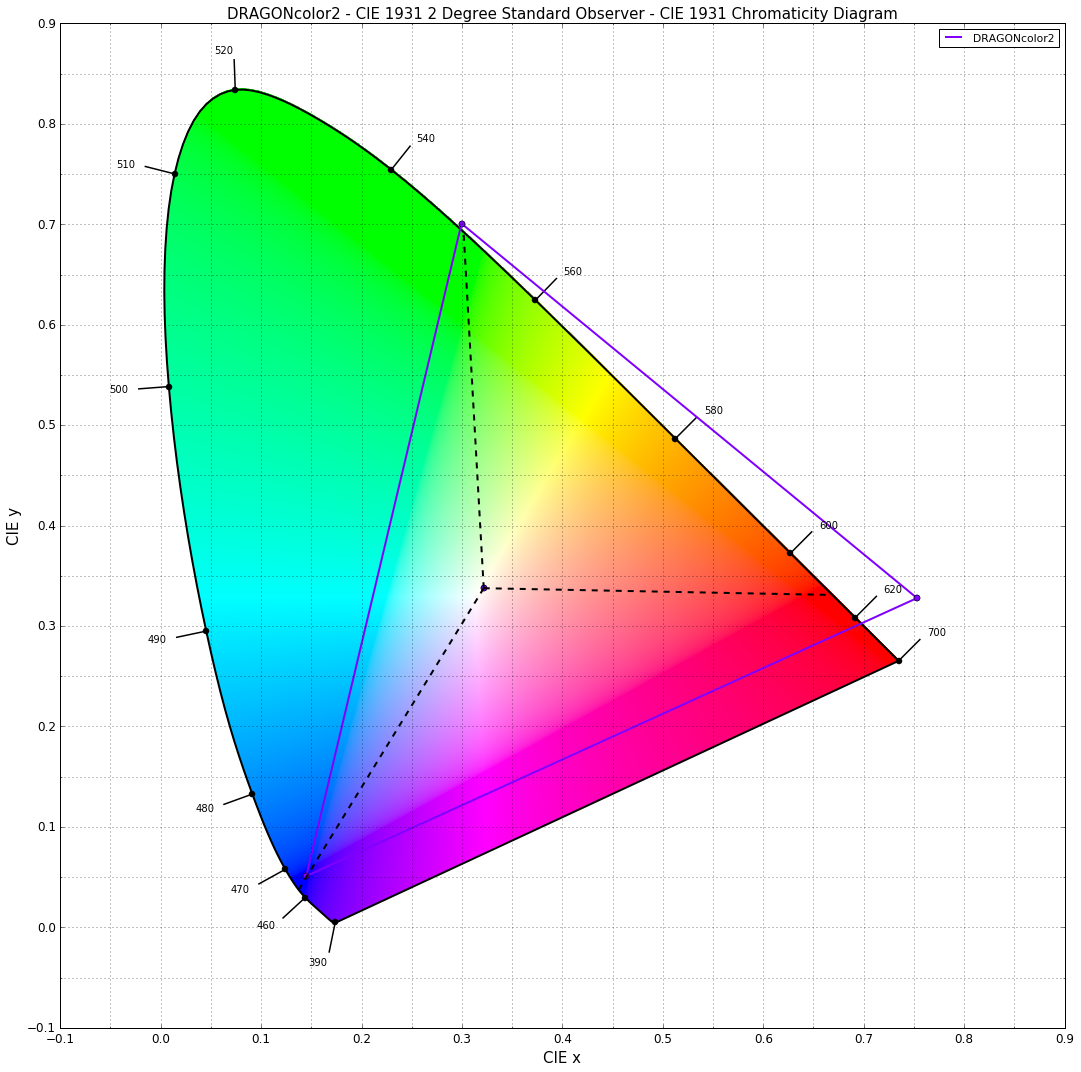

In [4]:
import pylab

from colour import DRAGON_COLOR_2_COLOURSPACE
from colour.plotting import *

D60 = ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D60']

RGB_colourspaces_CIE_1931_chromaticity_diagram_plot(['DRAGONcolor2'], standalone=False)

for p in DRAGON_COLOR_2_COLOURSPACE.primaries:
    w, xy = dominant_wavelength(p, D60)
    pylab.plot((D60[0], xy[0]), (D60[1], xy[1]), '--', color='black', linewidth=2)

"[ 0.29957049  0.70069942]" chromaticity coordinates have no "complementary wavelength"!


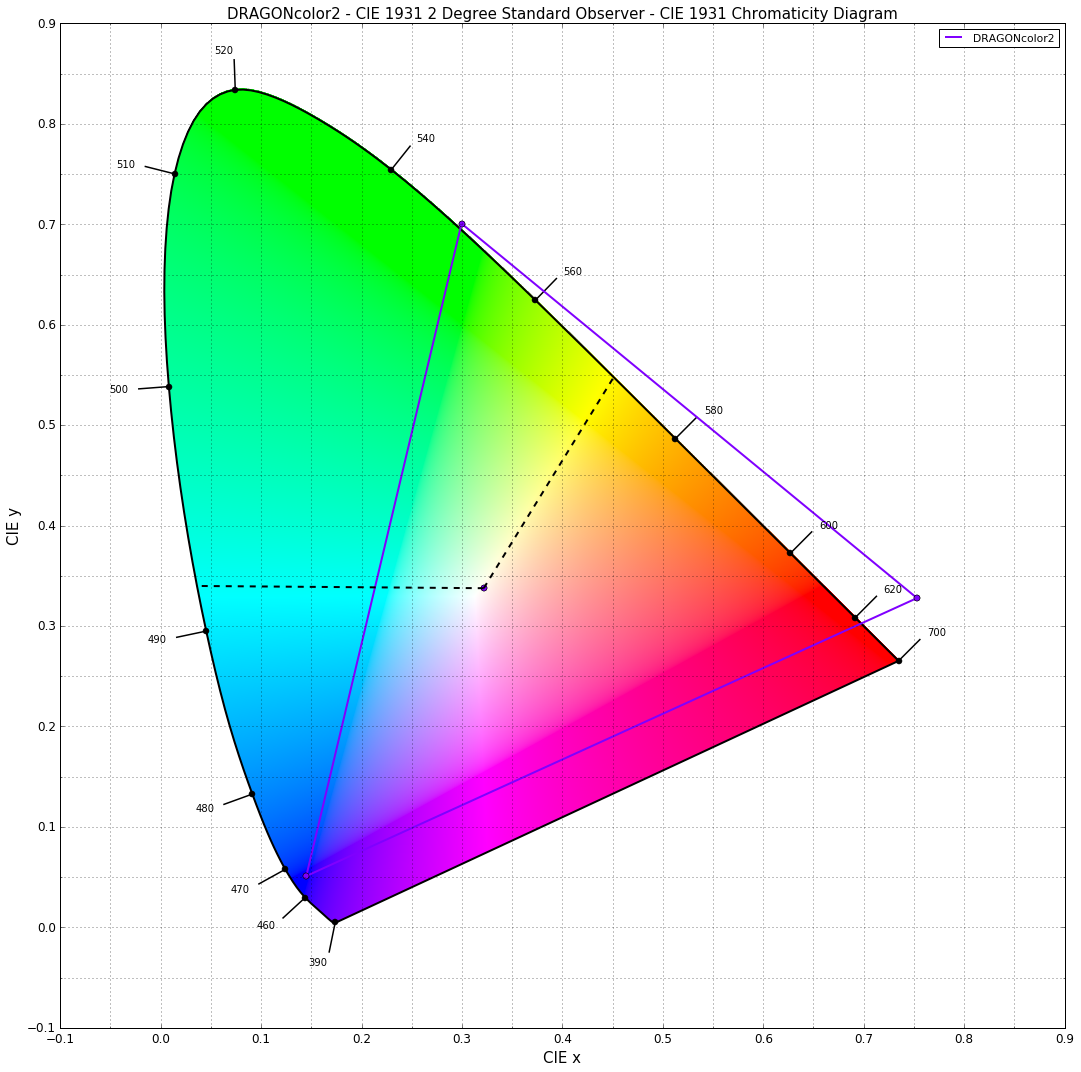

In [5]:
RGB_colourspaces_CIE_1931_chromaticity_diagram_plot(['DRAGONcolor2'], standalone=False)

for p in DRAGON_COLOR_2_COLOURSPACE.primaries:
    try:
        w, xy = complementary_wavelength(p, D60)
        pylab.plot((D60[0], xy[0]), (D60[1], xy[1]), '--', color='black', linewidth=2)
    except RuntimeError as e:
        print(e)
        

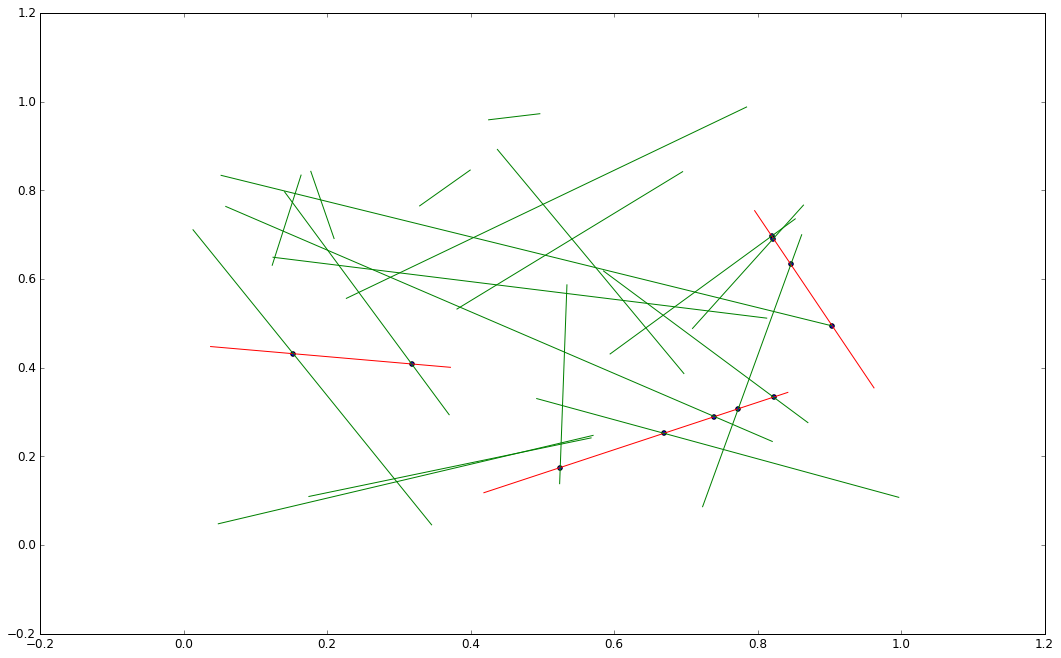

In [6]:
# http://www.mathworks.com/matlabcentral/fileexchange/27205-fast-line-segment-intersection

from collections import namedtuple

import matplotlib.pyplot
from matplotlib.collections import LineCollection

SegmentsIntersections_Specification = namedtuple(
    'SegmentsIntersections_Specification',
    ('intersect', 'xy', 'd1', 'd2', 'parallels', 'coincidents'))


def segments_intersections(xy1, xy2):
    xy1 = np.reshape(xy1, (-1, 4))
    xy2 = np.reshape(xy2, (-1, 4))

    r1, c1 = xy1.shape[0], xy1.shape[1]
    r2, c2 = xy2.shape[0], xy2.shape[1]

    x1, y1, x2, y2 = [np.tile(xy1[:, i, np.newaxis], (1, r2)) for i in range(c1)]

    xy2 = np.transpose(xy2)

    x3, y3, x4, y4 = [np.tile(xy2[i, :], (r1, 1)) for i in range(c2)]

    x4_x3 = x4 - x3
    y1_y3 = y1 - y3
    y4_y3 = y4 - y3
    x1_x3 = x1 - x3
    x2_x1 = x2 - x1
    y2_y1 = y2 - y1

    numerator_a = x4_x3 * y1_y3 - y4_y3 * x1_x3
    numerator_b = x2_x1 * y1_y3 - y2_y1 * x1_x3
    denominator = y4_y3 * x2_x1 - x4_x3 * y2_y1

    u_a = numerator_a / denominator
    u_b = numerator_b / denominator

    intersect = np.logical_and.reduce(
        (u_a >= 0, u_a <= 1, u_b >= 0, u_b <= 1))
    xy = tstack((x1 + x2_x1 * u_a, y1 + y2_y1 * u_a))
    xy[~intersect] = np.nan
    parallels = denominator == 0
    coincidents = np.logical_and.reduce(
        (numerator_a == 0, numerator_b == 0, parallels))
    
    return SegmentsIntersections_Specification(
        intersect, xy, u_a, u_b, parallels, coincidents)


# np.random.seed(3)

xy1 = np.random.rand(3, 2, 2)
xy2 = np.random.rand(20, 2, 2)

p = segments_intersections(xy1, xy2)

xy1_l = LineCollection(xy1, colors='red')
xy2_l = LineCollection(xy2, colors='green')

figure, axes = matplotlib.pyplot.subplots()

axes.add_collection(xy1_l)
axes.add_collection(xy2_l)
for i in range(xy1.shape[0]):
    matplotlib.pyplot.scatter(p.xy[i, :, 0], p.xy[i, :, 1])